# Book Recommendation System
## Collaborative Filtering and KMeans

We will  first import the important libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
books = pd.read_csv("../input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv", sep=';', encoding="latin-1", error_bad_lines=False)
users = pd.read_csv("../input/bookcrossing-dataset/Book reviews/Book reviews/BX-Users.csv", sep=';', encoding="latin-1", error_bad_lines=False)
ratings = pd.read_csv("../input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv", sep=';', encoding="latin-1", error_bad_lines=False)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


Data preprocessing (filling missing values and filtering some data)

In [3]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
users['Age'].fillna(value = users['Age'].mean(), inplace = True)
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",34.751434
1,2,"stockton, california, usa",18.000000
2,3,"moscow, yukon territory, russia",34.751434
3,4,"porto, v.n.gaia, portugal",17.000000
4,5,"farnborough, hants, united kingdom",34.751434


In [6]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271378 non-null  object
 3   Year-Of-Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
 5   Image-URL-S          271379 non-null  object
 6   Image-URL-M          271379 non-null  object
 7   Image-URL-L          271379 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       278858 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [10]:
books = books[~books['Year-Of-Publication'].isin(['DK Publishing Inc', 'Gallimard'])]
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'])
books.shape

(271379, 8)

In [11]:
books.dropna(axis = 0, how='any', inplace = True)
books.shape

(271376, 8)

## EDA

In [12]:
books.describe()

,Year-Of-Publication
count,271376.000000
mean,1959.755612
std,258.012755
min,0.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2050.000000


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Year-Of-Publication', ylabel='Density'>

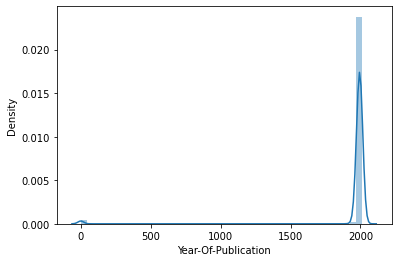

In [13]:
sns.distplot(books['Year-Of-Publication'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Year-Of-Publication', ylabel='Density'>

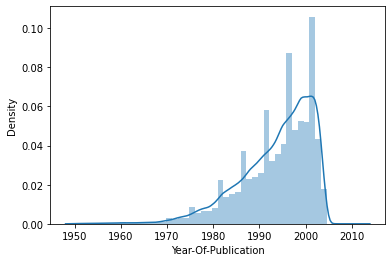

In [14]:
books = books[(books['Year-Of-Publication'] >= 1950) & (books['Year-Of-Publication'] <= 2016)]
sns.distplot(books['Year-Of-Publication'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

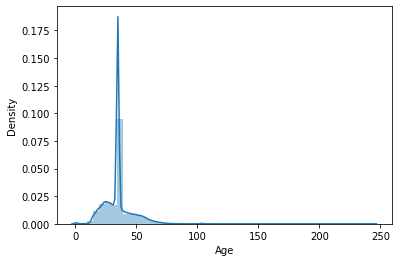

In [15]:
sns.distplot(users.Age)

In [16]:
users.Age.describe()

count    278858.000000
mean         34.751434
std          11.202003
min           0.000000
25%          29.000000
50%          34.751434
75%          35.000000
max         244.000000
Name: Age, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

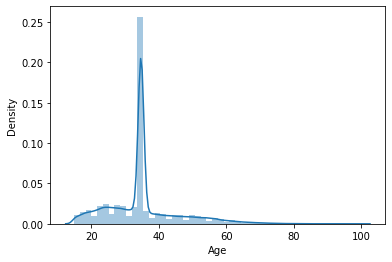

In [17]:
users = users[(users.Age >= 15) & (users.Age <= 100)]
sns.distplot(users.Age)

## Data Cleaning

In [18]:
ratings.shape

(1149780, 3)

In [19]:
ratings = ratings[ratings['ISBN'].isin(list(books['ISBN'].unique()))]

In [20]:
ratings = ratings[ratings['User-ID'].isin(list(users['User-ID'].unique()))]

In [21]:
ratings.shape

(1003152, 3)

## Collaborative Filtering

In [22]:
#Mean of ratings given by each user
mean_users_rating = ratings.groupby('User-ID')['Book-Rating'].mean()
users_rating = ratings.set_index('User-ID')
users_rating['mean-rating'] = mean_users_rating
users_rating.reset_index(inplace = True)

In [23]:
#Books in which users likes the book
users_rating = users_rating[users_rating['Book-Rating'] > users_rating['mean-rating']]

In [24]:
users_rating['is_fav'] = 1

In [25]:
users_rating.shape

(304848, 5)

In [26]:
users_rating.head()

,User-ID,ISBN,Book-Rating,mean-rating,is_fav
4,276729,0521795028,6,4.5,1
13,276747,0060517794,9,5.0,1
16,276747,0671537458,9,5.0,1
17,276747,0679776818,8,5.0,1
18,276747,0943066433,7,5.0,1


In [27]:
val = users_rating['User-ID'].value_counts()
list_to_keep = list(val[(val>10) & (val<100)].index)
users_rating = users_rating[users_rating['User-ID'].isin(list_to_keep)]
users_rating.shape

(133773, 5)

In [28]:
users_rating.describe()

,User-ID,Book-Rating,mean-rating,is_fav
count,133773.000000,133773.000000,133773.000000,133773.0
mean,140065.513228,7.876066,3.805438,1.0
std,79596.274187,1.657648,1.935174,0.0
min,242.000000,1.000000,0.019385,1.0
25%,71853.000000,7.000000,2.337423,1.0
50%,138995.000000,8.000000,3.588235,1.0
75%,209160.000000,9.000000,4.983607,1.0
max,278851.000000,10.000000,9.941176,1.0


## Creating pivot tables for user and books

In [29]:
df = pd.pivot_table(users_rating, index = 'User-ID', columns = 'ISBN', values = 'is_fav')
df.fillna(value = 0, inplace = True)
df.shape

(4790, 68443)

In [30]:
df.head(15)

ISBN,0001047973,000104799X,0001048082,0001360469,0001374362,0001374869,000160418X,0001714600,0001821326,0001941941,...,B00009EF82,B00009MBYK,B0000AZW79,B0000C2W5U,B0000DAPP1,B0000T6KIM,B0000VZEH8,B00011SOXI,B0001FZGRQ,B0001GMSV2
User-ID,,,,,,,,,,,,,,,,,,,,,
242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## PCA - Dimensionality reduction

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(df)
pca_fit = pca.transform(df)

In [32]:
pca_fit = pd.DataFrame(pca_fit, index = df.index)
pca_fit

,0,1,2
User-ID,,,
242,-0.206647,-0.022092,0.002429
243,0.311817,-0.258237,0.007734
254,0.640734,1.905327,0.070266
388,-0.155537,-0.040534,0.003890
392,-0.196654,-0.023315,0.000288
...,...,...,...
278535,-0.092345,-0.021796,0.095813
278582,-0.018778,-0.091226,0.007476
278633,0.777334,-0.482100,0.512042


## Clustering using KMeans

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score ,silhouette_samples

from IPython.display import Image,display
from IPython.core.display import HTML
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


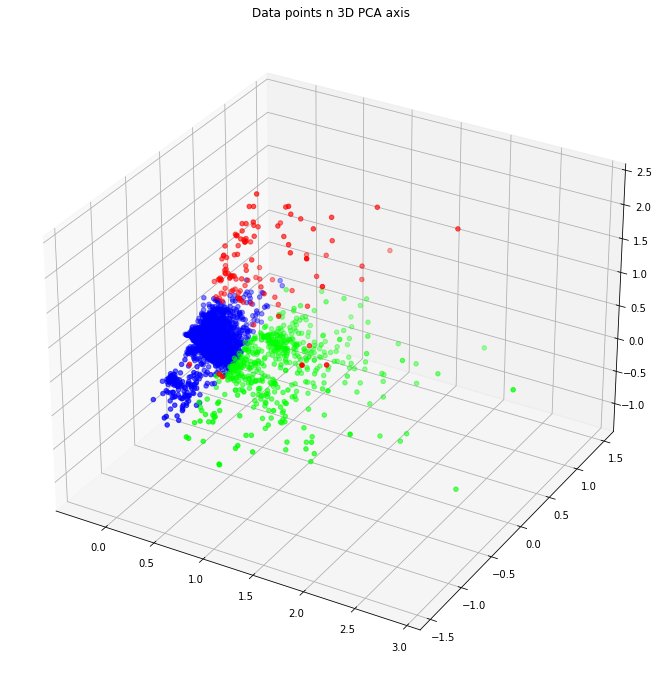

In [34]:
km = KMeans(n_clusters = 3)
plt.rcParams['figure.figsize'] = (16, 9)
clusters =km.fit_predict(pca_fit)
cmhot = plt.get_cmap('brg')
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pca_fit[0], pca_fit[2], pca_fit[1], c = clusters, cmap = cmhot)
plt.title('Data points n 3D PCA axis')
plt.show()

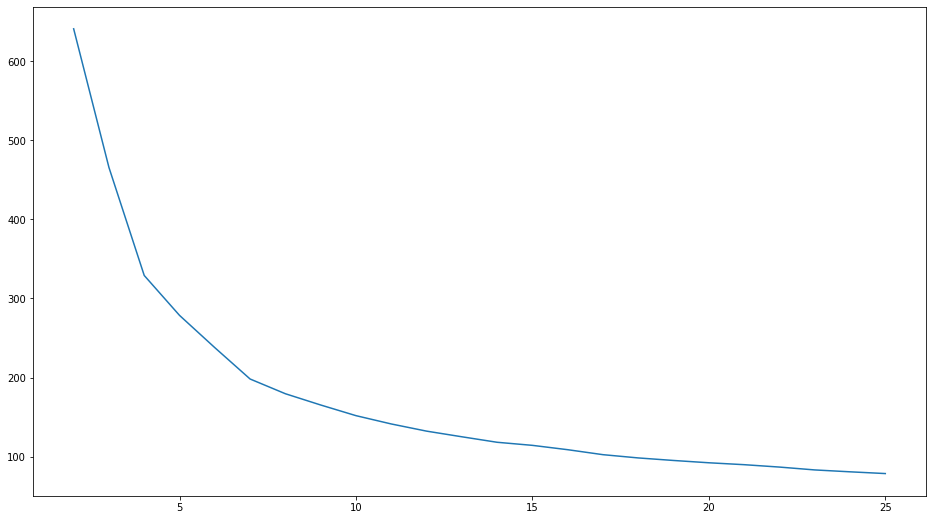

In [35]:
tss = []
for i in range(2, 26):
    km = KMeans(n_clusters = i, random_state = 0)
    km.fit(pca_fit)
    tss.append(km.inertia_)
plt.plot(range(2, 26), tss, '-')

For n_clusters = 3 The average silhouette_score is : 0.6595745711208627
For n_clusters = 4 The average silhouette_score is : 0.6942685003710171
For n_clusters = 5 The average silhouette_score is : 0.5188700830658752
For n_clusters = 6 The average silhouette_score is : 0.5498493621392182
For n_clusters = 7 The average silhouette_score is : 0.5533182387418084
For n_clusters = 8 The average silhouette_score is : 0.5371233089366926


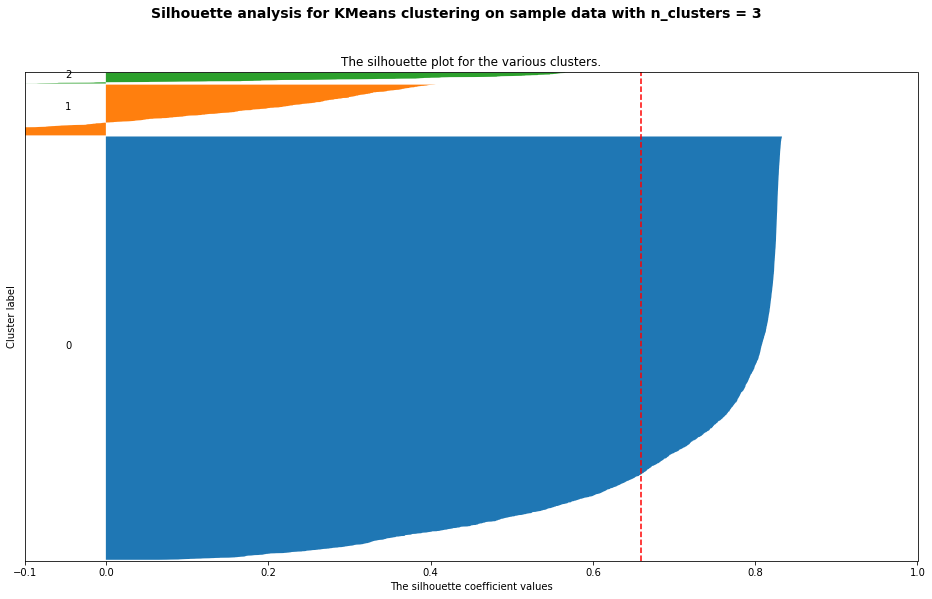

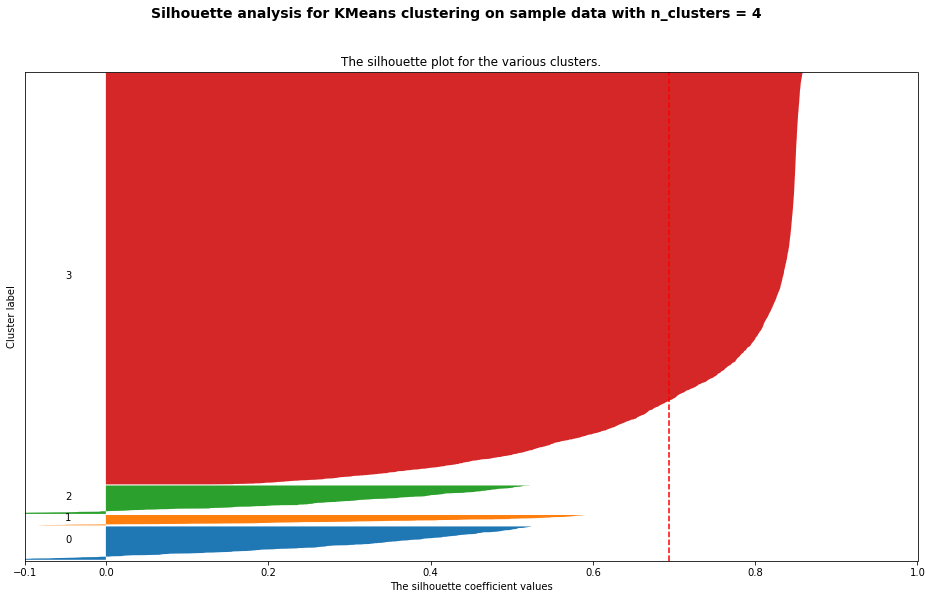

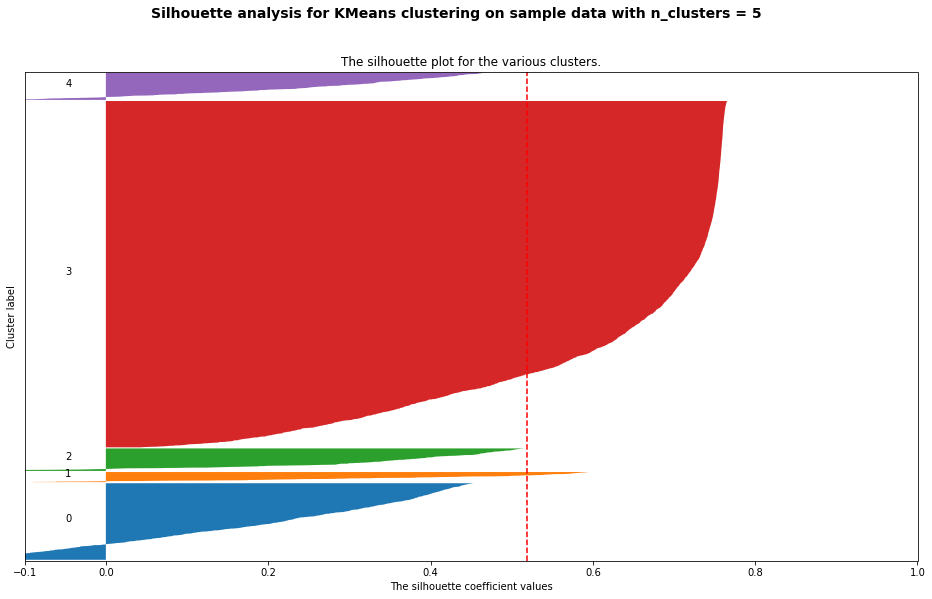

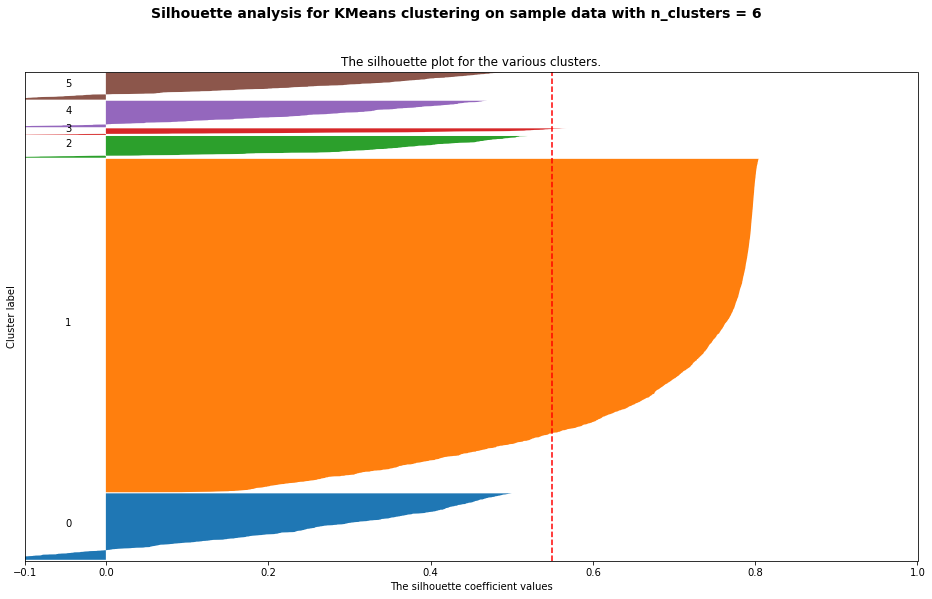

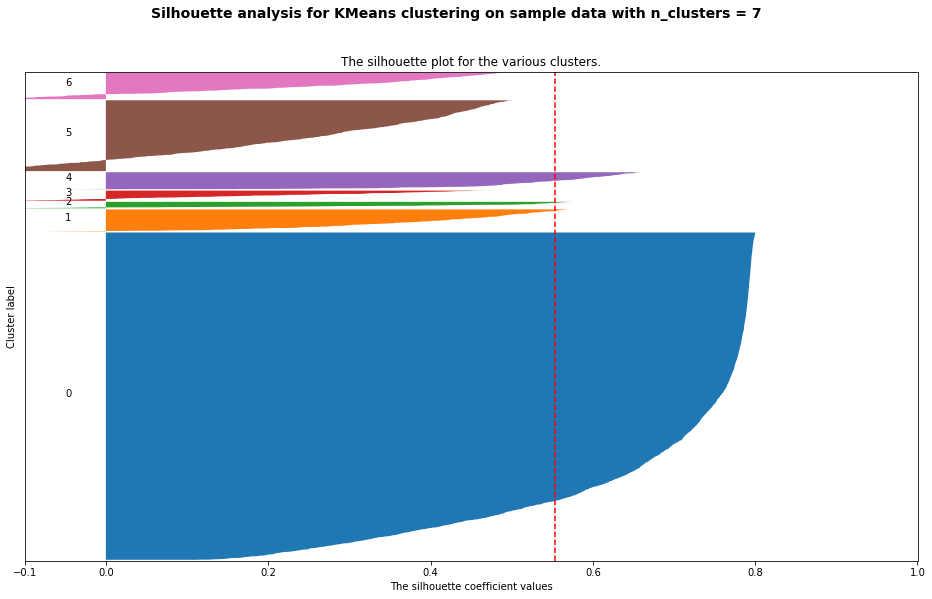

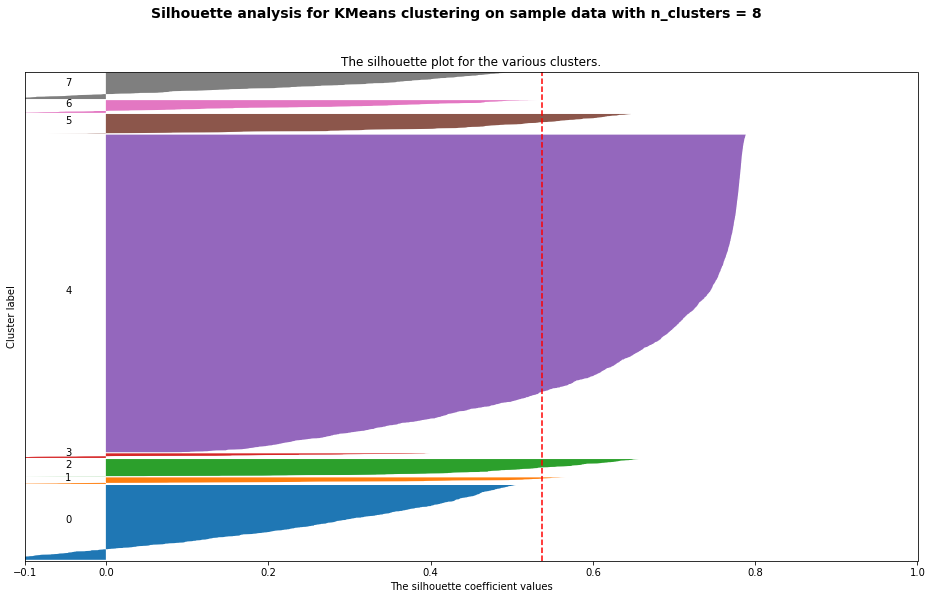

In [36]:
for n in [3,4,5,6,7,8]:
    ax1 = plt.figure().gca()
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(pca_fit) + (n + 1) * 10])
    km = KMeans(n_clusters=n,random_state=0)
    clusters = km.fit_predict(pca_fit)
    silhouette_avg = silhouette_score(pca_fit, clusters)
    print("For n_clusters =", n,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_values = silhouette_samples(pca_fit, clusters)
    y_start = 10
    for i in range(n): 
        ith_cluster = np.sort(silhouette_values[clusters==i])
        cluster_size = ith_cluster.shape[0]
        y_end = y_start + cluster_size 
        ax1.fill_betweenx(np.arange(y_start, y_end),
                          0, ith_cluster)
        ax1.text(-0.05, y_start + 0.5 * cluster_size, str(i))
        y_start = y_end + 10
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n),
                 fontsize=14, fontweight='bold')
plt.show()

K = 4 will show the best clustering

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  after removing the cwd from sys.path.


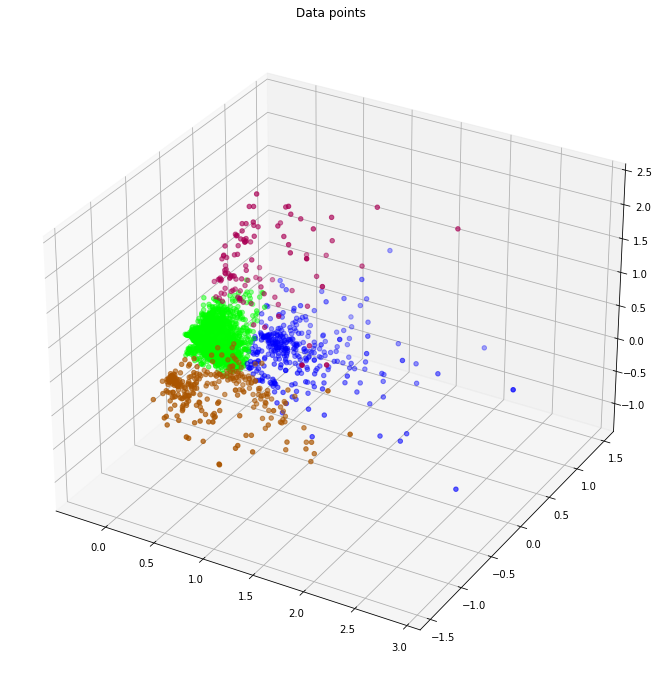

In [37]:
kmeans_4 = KMeans(n_clusters = 4, random_state = 0).fit(pca_fit)
df['cluster'] = kmeans_4.labels_
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pca_fit[0], pca_fit[2], pca_fit[1], c = df['cluster'], cmap = cmhot)
plt.title('Data points')
plt.show()

In [38]:
#Books for each clusters
c1_books = df[df.cluster == 0].mean()
c2_books = df[df.cluster == 1].mean()
c3_books = df[df.cluster == 2].mean()
c4_books = df[df.cluster == 3].mean()

In [39]:
#Users for each clusters
c1_users = df[df.cluster == 0].index
c2_users = df[df.cluster == 1].index
c3_users = df[df.cluster == 2].index
c4_users = df[df.cluster == 3].index

## Clusters analysis
**Cluster 1**

In [40]:
def cluster_books_des(Ser):
    bks = pd.DataFrame(Ser).merge(books,left_index=True,right_on='ISBN',how='left')
    bks.rename(columns={0:'avg_score'},inplace=True)
    bks.sort_values(by='avg_score',ascending=False,inplace=True)
    print('Median Year:',int(bks['Year-Of-Publication'].median()))
    print('\nTop 5 Books\n')
    Top5_books = bks.index[:5]
    for i,isbn in enumerate(Top5_books):
        print(str(i+1)+'.',bks.loc[isbn]['Book-Title'])
    Top5_authors = bks['Book-Author'].unique()[:5]
    print('Top 5 Authors\n')
    for i,auth in enumerate(Top5_authors):
        print(str(i+1)+'.',auth)
cluster_books_des(c1_books)

Median Year: 1997

Top 5 Books

1. The Lovely Bones: A Novel
2. Where the Heart Is (Oprah's Book Club (Paperback))
3. The Pilot's Wife : A Novel
4. She's Come Undone (Oprah's Book Club)
5. Divine Secrets of the Ya-Ya Sisterhood: A Novel
Top 5 Authors

1. Alice Sebold
2. Billie Letts
3. Anita Shreve
4. Wally Lamb
5. Rebecca Wells


Most Common Location: sacramento, california, usa

Mean Age: 34.56753673846566


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


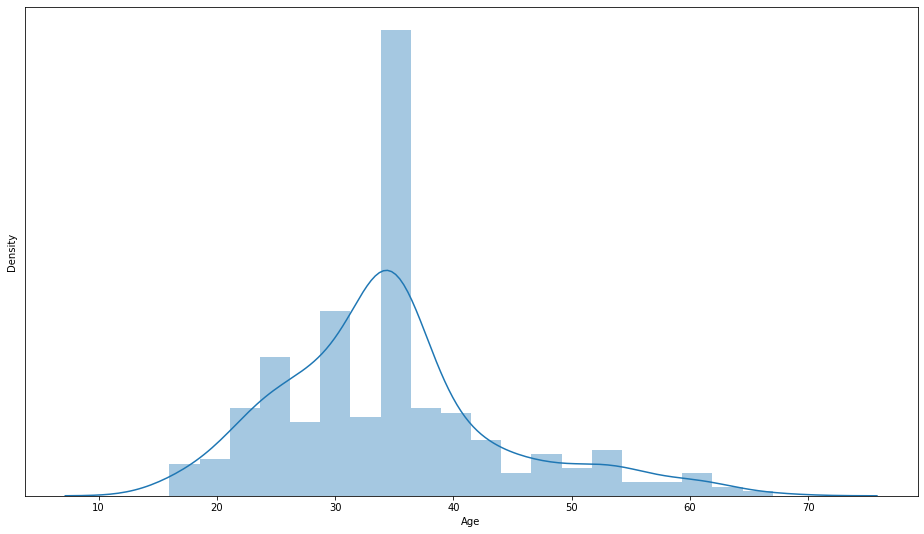

In [41]:
def cluster_user_des(Ser):
    cl_user = users[users['User-ID'].isin(list(Ser))]
    print('Most Common Location:',cl_user['Location'].mode()[0])
    print('\nMean Age:',cl_user['Age'].mean())
    sns.distplot(cl_user['Age'])
    plt.yticks([])
cluster_user_des(c1_users)

In [42]:
cluster_books_des(c2_books.drop('cluster'))

Median Year: 1997

Top 5 Books

1. Harry Potter and the Chamber of Secrets (Book 2)
2. Harry Potter and the Prisoner of Azkaban (Book 3)
3. Harry Potter and the Order of the Phoenix (Book 5)
4. Harry Potter and the Goblet of Fire (Book 4)
5. Harry Potter and the Sorcerer's Stone (Book 1)
Top 5 Authors

1. J. K. Rowling
2. J.D. Salinger
3. J.R.R. TOLKIEN
4. Thomas Harris
5. Harper Lee


Most Common Location: edmonton, alberta, canada

Mean Age: 30.585104570388815


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


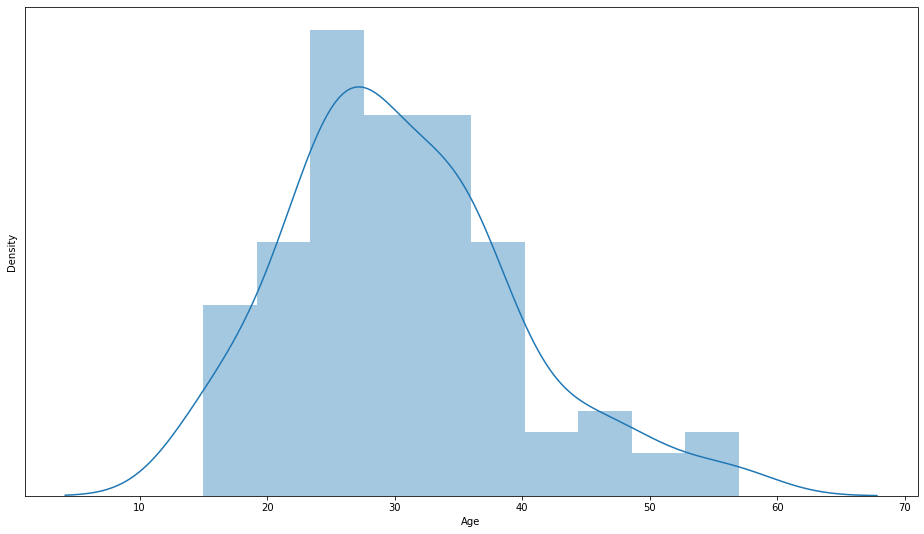

In [43]:
cluster_user_des(c2_users)

**Cluster 3**

In [44]:
cluster_books_des(c3_books.drop('cluster'))

Median Year: 1997

Top 5 Books

1. The Da Vinci Code
2. Angels & Demons
3. The Secret Life of Bees
4. The Red Tent (Bestselling Backlist)
5. The Five People You Meet in Heaven
Top 5 Authors

1. Dan Brown
2. Sue Monk Kidd
3. Anita Diamant
4. Mitch Albom
5. Jennifer Weiner


Most Common Location: portland, oregon, usa

Mean Age: 36.533182722841254


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


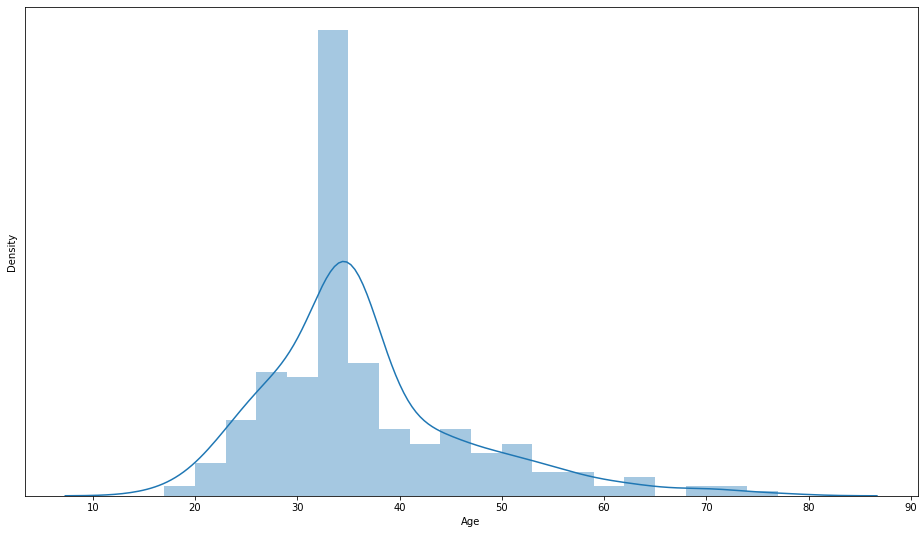

In [45]:
cluster_user_des(c3_users)

**Cluster 4**

In [46]:
cluster_books_des(c4_books.drop('cluster'))

Median Year: 1997

Top 5 Books

1. Interview with the Vampire
2. Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
3. Jurassic Park
4. The Red Tent (Bestselling Backlist)
5. To Kill a Mockingbird
Top 5 Authors

1. Anne Rice
2. J. K. Rowling
3. Michael Crichton
4. Anita Diamant
5. Harper Lee


Most Common Location: toronto, ontario, canada

Mean Age: 35.48797242389766


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


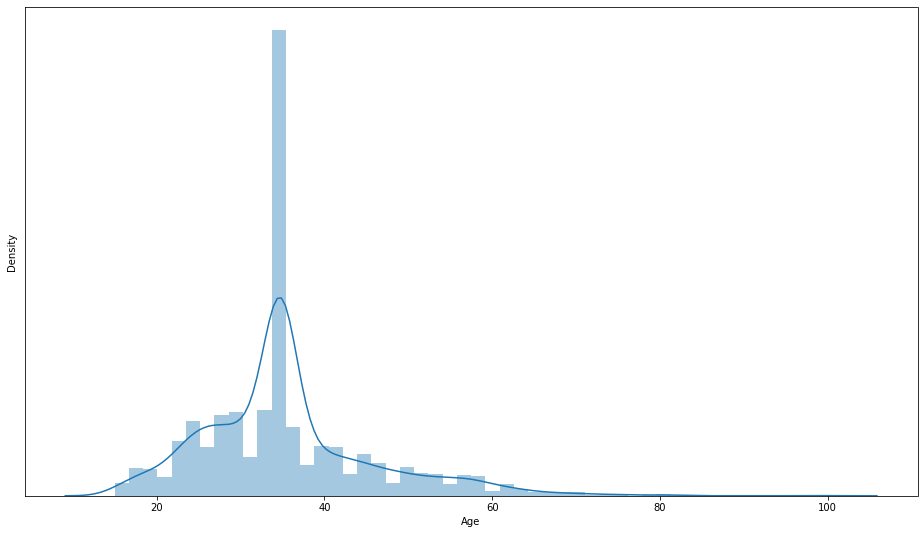

In [47]:
cluster_user_des(c4_users)